# Trophic model for gut
## Consumer-Resource model (CRM) with Trophic levels
The human gut microal community is complex because of 3 reason: (1) many microbial species (~570); (2) many metabolites involoved (~244); and (3) many microbe-metabolite interactions/links (>4400). Of all types of microbe-metabolite interactions/links, the cross-feeding makes the system more complicated to interpret. Previously, a literature-curated interspecies network of the human gut microbiota, called [NJS16](https://www.nature.com/articles/ncomms15393) is reported. This is an extensive data resource composed of ∼570 microbial species and 3 human cell types metabolically interacting through >4,400 small-molecule transport and macromolecule degradation events.

Here, we devoted to build a Consumer-Resource model (CRM) with trophic levels posted in the paper "[a evidence for a multi-level trophic organization of the human gut microbiome](https://www.biorxiv.org/content/10.1101/603365v1.full-text)". The model is devoted to study the complex microbe-metabolite network in human guts.

In concise, in the mode, a trophic level is considered as one round of carbon processing and is composed of two process: resource allocation to microbes and the following resource/byproduct generation by microbes. The simulation is stopped after several trophic levels because the residence time of resource in the human gut is assumed to be finite.

Previously, the code for the model is written in Matlab. Here a Python version of the model is proposed, providing further convenience for Machine Learning model to learn uptake rates and byproduct generation rates of all microbial species to different metabolites.

In [20]:
########### Self-customized setting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
import math
from numba import jit, float64

#%% Plot Tong's default setting
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 3


In [21]:
########### import the pickled file containing all processed data which are useful for simulations (the processing is
########### done in "Trophic_model_for_gut_data_processing.ipynb")
import pickle
pickle_in = open("Chia_network.pickle","rb")
net, i_selfish, i_intake, names = pickle.load(pickle_in)

pickle_in = open("Thai_data.pickle","rb")
thai_metagenome_ID, thai_metagenome, thai_metabolome_ID, thai_metabolome = pickle.load(pickle_in)


## Create maps of microbes and metabolites to their reduced matrix forms

In [22]:
#i_nonzero_microbes = net['microbes_ID'].unique()
#i_nonzero_microbes = np.sort(i_nonzero_microbes)
i_nonzero_microbes = thai_metagenome_ID.values.copy()
i_nonzero_metabolites = net['metabolites_ID'].unique()
i_nonzero_metabolites = np.sort(i_nonzero_metabolites)


df_metabolites = pd.DataFrame.from_dict({'oldID': i_nonzero_metabolites, 'newID':list(range(len(i_nonzero_metabolites)))})
df_metabolites.set_index('oldID', inplace=True)
df_microbes = pd.DataFrame.from_dict({'oldID': i_nonzero_microbes, 'newID':list(range(len(i_nonzero_microbes)))})
df_microbes.set_index('oldID', inplace=True)


outgoingNodes = df_metabolites.loc[net['metabolites_ID'].values].values.flatten()
ingoingNodesTemp = df_microbes.loc[net['microbes_ID'].values].values.flatten()
edge_types = net.iloc[~np.isnan(ingoingNodesTemp),2].values
outgoingNodes = outgoingNodes[~np.isnan(ingoingNodesTemp)]
ingoingNodes = ingoingNodesTemp[~np.isnan(ingoingNodesTemp)].astype(int)

net_reduced = pd.DataFrame.from_dict({'metabolites': outgoingNodes, 'microbes':ingoingNodes, 'edgeType':edge_types})
net = net_reduced.copy()
net_chia = net.copy()

thai_metagenome_ID_reduced = df_microbes.loc[thai_metagenome_ID].values.flatten()
thai_metagenome_ID = thai_metagenome_ID_reduced[~np.isnan(thai_metagenome_ID_reduced)].astype(int)

thai_metabolome_ID_reduced = df_metabolites.loc[thai_metabolome_ID].values.flatten()
thai_metabolome_ID = thai_metabolome_ID_reduced[~np.isnan(thai_metabolome_ID_reduced)].astype(int)


i_selfish_reduced = df_microbes.loc[i_selfish].values.flatten()
i_selfish = i_selfish_reduced[~np.isnan(i_selfish_reduced)].astype(int)

i_intake_reduced = df_metabolites.loc[i_intake].values.flatten()
i_intake = i_intake_reduced[~np.isnan(i_intake_reduced)].astype(int)


/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


## Run the simulation with reduced matrix forms for one individual

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.4350254292045665
            Iterations: 10
            Function evaluations: 227
            Gradient evaluations: 10
     fun: 2.4350254292045665
     jac: array([ 0.        , -0.00853819,  0.07028782,  0.00888675,  0.5158169 ,
        0.00695616,  0.5158169 , -0.00318575,  0.23650047, -0.00714117,
        0.23884735,  0.1009917 ,  0.07105842, -0.00713146, -0.00863993,
        0.09273681,  0.5424481 ,  0.61806461, -0.01410729, -0.00784275])
 message: 'Optimization terminated successfully.'
    nfev: 227
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([5.00000000e-02, 1.18522175e+00, 6.05657813e-15, 5.55845978e-02,
       5.76567800e-15, 7.84340336e-01, 5.83405308e-15, 1.46314133e-02,
       4.17078655e-15, 1.16066460e+00, 5.15701444e-15, 6.37199005e-15,
       5.19076232e-15, 1.15865506e+00, 1.17948029e+00, 5.46294989e-15,
       6.60426658e-15, 5.89703126e-15, 1.27764841

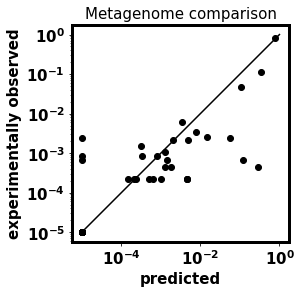

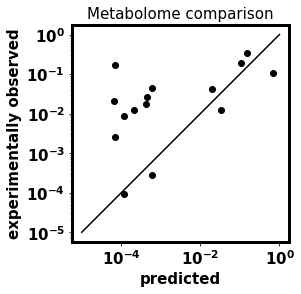

In [23]:
################################# Predict metabolome from individual's metagenome.
from numpy import array
from scipy.sparse import csr_matrix
import numpy.matlib
from scipy.optimize import minimize, rosen, rosen_der
from scipy.stats import pearsonr

MAX_ID_microbes = len(i_nonzero_microbes)  # MAX_ID_microbes is the maximum of ID labels for microbes.
MAX_ID_metabolites = len(i_nonzero_metabolites)  # MAX_ID_metabolites is the maximum of ID labels for metabolites.

def Ain_out(b_real, net):
    '''
    Ain_out is a function used to create sparse matrices made of metabolites and microbes 
    where metabolite consumption and production is considered. The matrices created are "m2b" and "b2m":
    (1) m2b is a matrix determines the nutrient splitting among microbes, and
    (2) b2m is a matrix determines the byproducts generation.
    Both matrices have rows representing bacterial species and columns representing metablolites.
    Two matrices are created based on (1) the metabolite consumption and production network which is 
    encode in "net" as a dataframe, and (2) the experimentally measured bacterial abundance "b_real".
    '''
    valid_index = np.where((net['edgeType']==2) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    m2b = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    valid_index = np.where((net['edgeType']==3) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    b2m = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    ########## Normalize the b2m by out_degree
    out_degree = b2m.sum(0).copy()
    out_degree[out_degree==0]=100
    b2m = (b2m / out_degree)

    ########## Normalize the m2b by proportion of microbial abundance in each individual
    b_real_repmat = numpy.matlib.repmat(b_real[np.newaxis,:], MAX_ID_metabolites, 1)
    m2b = m2b * b_real_repmat
    in_degree = m2b.sum(1)
    in_degree[in_degree==0]=100
    m2b = m2b / numpy.matlib.repmat(in_degree[:,np.newaxis], 1, MAX_ID_microbes)
    m2b = np.float32(m2b)
    b2m = np.float32(b2m)
    return [m2b, b2m]

def m2b_multiple_levels(f, m2b, b2m, numLevels_max):
    '''
    m2b_multiple_levels is a function used to generate matrices involving the calculation of metabolite 
    byproducts and microbial biomass after several trophic levels/layers. Those matrices are:
    (1) m2m_layer is a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic
    level or layer.
    (2) m2m_total is a conversion matrix from the nutrient intake to a summation of metabolite byproducts at
    all trophic levels or layers.
    (3) m2b_total is a conversion matrix from the nutrient intake to a summation of all microbial/bacterial 
    biomass gain at all trophic levels or layers.
    Those matrices are computed based on (1) metabolite consumption matrix "m2b", (2) metabolite byproduct
    generation matrix "b2m", (3) byproduct/leakage fraction "f", and (4) number of trophic levels/layers in the 
    simulation "numLevels_max".
    '''
    m2m_layer = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites, numLevels_max));  
    #m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_microbes));  
    m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites));  
    
    f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    #s_step =  np.dot(b2m, m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step =  np.dot(b2m, f_mul*m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step_ii = np.eye(MAX_ID_metabolites, MAX_ID_metabolites);
    #f_mul = numpy.matlib.repmat(f[np.newaxis,:], MAX_ID, 1)#numpy.matlib.repmat(f, 1, MAX_ID)
    #f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    
    for ii in range(numLevels_max):
        # m2b_total is a series made of s_step of each layer
        #m2b_total = m2b_total + f_mul**(ii) * s_step_ii
        #m2m_layer[:,:,ii] = f_mul**(ii) * s_step_ii
        m2b_total = m2b_total + s_step_ii
        m2m_layer[:,:,ii] = s_step_ii
        s_step_ii = np.dot(s_step_ii, s_step);  
    m2m_total = m2b_total;
    m2b_total = np.dot((1 - f_mul) * m2b.T, m2b_total) # m2b_total has an extra multiplication of m2b and (1-f).
    return [m2b_total, m2m_total, m2m_layer]

def pred_error(x, b_real, m2b_total, i_intake):
    '''
    pred_error is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    ba_pred = np.dot(m2b_total, x_full)
    pred_error = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    pred_error = np.sqrt(np.dot(pred_error, pred_error.T)) #np.sqrt(np.sum(pred_error**2))
    return pred_error

def calc_metabolome(x, m2m_layer, numLevels_max, i_intake):
    '''
    calc_metabolome is a function used to calculate the metabolome from the fitted nutrient intake from the
    model. It relies on (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2m_layer: 
    a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic level or layer, 
    and (4) numLevels_max: the number of trophic levels/layers in the model. The metabolome in the model is 
    assumed to be composed of two parts: (1) met_levels: all metabolites in the final trophic level/layer 
    (which is considered to be reaching the end of the gut because of the finite gut length and gut motility.),
    and (2) met_leftover_levels: all unusable metabolites from all previous trophic levels/layers. 
    '''
    i_unused = np.where(np.sum(m2b.T,0) == 0)[0]
    met_levels = np.zeros((MAX_ID_metabolites, numLevels_max));  
    met_leftover_levels = np.zeros((MAX_ID_metabolites, numLevels_max));
    
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    for ii in range(numLevels_max):
        met_levels[:,ii] = np.dot(m2m_layer[:,:,ii], x_full)
        if ii==0:
            met_leftover_levels[i_unused,ii] = x_full[i_unused]
        else:
            met_leftover_levels[i_unused,ii] = met_levels[i_unused,ii-1]
            
    return [met_levels, met_leftover_levels]

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 1; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))


In [24]:
len(metabolome_measured_common)


15

## Run the simulation with reduced matrix forms for all individuals

In [25]:
corr_list = np.zeros((41,2))
diet_list = np.zeros((41, 20))
for pa in range(41):
    print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    diet_list[pa, :] = res.x

    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))

0
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.4264852667826321, 0.009492041976102554)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.6105969010967452, 0.0071135444908271405)
1
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.9011443329682665, 1.1288354642116656e-11)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.3331254965868357, 0.22501672112879326)
2
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the 

-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.7630536992550145, 1.627860770711474e-08)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.7889371777083002, 5.954638506268544e-05)
21
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:
(0.7700035345916794, 6.378434244443953e-08)
(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:
(0.4056716822024301, 0.09486510648118715)
22
-------------------------------------------------------------------------------------------------------------
(Correlation coefficient, P-value) of the 

In [26]:
np.mean(corr_list[:,1])


0.6108124558596347

In [45]:
pDel_list = np.arange(0.0, 1.0, 0.1)
correlation = np.zeros((len(pDel_list), 10))
log10accuracy = np.zeros((len(pDel_list), 10))
numMetabolites = np.zeros((len(pDel_list), 10))

for roundpDel in range(len(pDel_list)):
    for roundOfReplicate in range(10):
        pDel = pDel_list[roundpDel]
        
        net = net_chia.copy()
        i_x = np.random.choice(range(len(net_chia)), int(len(net_chia) * pDel), replace=False)
        #net.drop(i_x, inplace=True)
        net.drop(net.index[i_x], inplace=True)

        corr_list = np.zeros((41,2))
        diet_list = np.zeros((41, 20))
        log10_list = np.zeros((41))
        numMetabolites_list = np.zeros((41))
        for pa in range(41):
            #print(pa)
            ######## Select an ID of a individual and pull out its experimentally measured metagenome:
            b_real = np.zeros((MAX_ID_microbes,))
            b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

            ######## Compute matrices involving the metabolite consumption and generation:
            m2b, b2m = Ain_out(b_real, net)
            #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
            m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

            ######## Assign diet
            x0 = np.ones((len(i_intake),)) / len(i_intake)

            ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
            # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
            # from the model for a certain nutrient intake.
            fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
            bnds = ((0, 100), ) * len(x0)
            res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

            ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
            # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
            # visually and statistically compared to the experimentally measured metagenome and metabolome.
            x_full = np.zeros((MAX_ID_metabolites,));
            x_full[i_intake] = res.x;
            ba_pred = np.dot(m2b_total, x_full)

            met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
            metabolome_measured = np.zeros((MAX_ID_metabolites,))
            metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
            metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
            i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
            metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
            metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])
            numMetabolites_list = i_common.shape[0]

            corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
            #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
            if i_common.shape[0] >= 2:
                corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
            else:
                corr_list[pa, 1] = 0
            diet_list[pa, :] = res.x
            if i_common.shape[0] >= 1:
                log10_list[pa] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-5) - np.log10(metabolome_measured_common+1e-5)))
            else:
                log10_list[pa] = 5
            '''
            print('-------------------------------------------------------------------------------------------------------------')
            print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
            print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
            print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
            print(pearsonr(metabolome_pred_common, metabolome_measured_common))
            '''
        print(np.mean(corr_list[:,1]))
        correlation[roundpDel, roundOfReplicate] = np.mean(corr_list[:,1])
        log10accuracy[roundpDel, roundOfReplicate] = np.mean(log10_list)
        numMetabolites[roundpDel, roundOfReplicate] = np.mean(numMetabolites_list)
        

0.6108124558596347
0.6108124558596347
0.6108124558596347
0.6108124558596347
0.6108124558596347
0.6108124558596347
0.6108124558596347
0.6108124558596347
0.6108124558596347
0.6108124558596347
0.6427164689730017
0.6447136811274219
0.6093388111723385
0.5973778603695767
0.6126862331529237
0.6279879631567362
0.596629445934351
0.623631522889699
0.6080203939932552
0.5690225899659901
0.6345543303122815
0.5917953552430545
0.5974866972228273
0.6305485472962483
0.5883314358435154
0.6286673378699627
0.5580518604998613
0.6364044379515237
0.5379512077326427
0.6231557301393534
0.6263782341327093
0.6270352110206441
0.44122835787145387
0.6003729541297143
0.5772301552914774
0.5084651582431611
0.6288414469075863
0.5443390250599154
0.5556389198347365
0.5159535257823311
0.5529225514552586
0.5639899944695035
0.3875400922414013
0.4568631770109396
0.5554422348427135
0.4993814759404157
0.4868178450943641
0.5740233064169487
0.5108941044303589
0.4501689839252196
0.4178118687008034
0.4826312422504437
0.61632767952

/Users/tongwang/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


nan
-0.3887111098417681
0.1474701923767245
0.1785686410959179
nan
0.04672229690679191


Text(0, 0.5, 'number of metabolites')

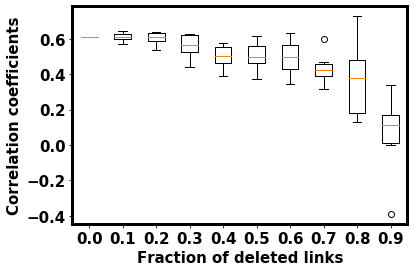

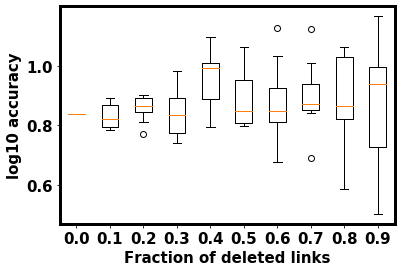

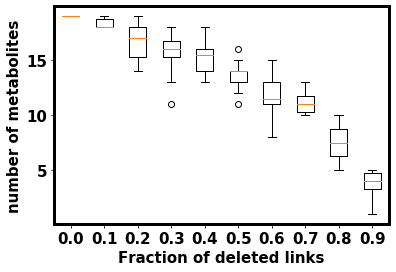

In [47]:
plt.figure()
correlation[np.isnan(correlation)] = 0
plt.boxplot(correlation.transpose());
plt.xticks(np.array(list(range(len(pDel_list))))+1, np.round(pDel_list,2));
plt.xlabel('Fraction of deleted links')
plt.ylabel('Correlation coefficients')
#np.array(list(range(len(pDel_list))))

plt.figure()
log10accuracy[np.isnan(log10accuracy)] = 0
plt.boxplot(log10accuracy.transpose());
plt.xticks(np.array(list(range(len(pDel_list))))+1, np.round(pDel_list,2));
plt.xlabel('Fraction of deleted links')
plt.ylabel('log10 accuracy')
#np.array(list(range(len(pDel_list))))

plt.figure()
plt.boxplot(numMetabolites.transpose());
plt.xticks(np.array(list(range(len(pDel_list))))+1, np.round(pDel_list,2));
plt.xlabel('Fraction of deleted links')
plt.ylabel('number of metabolites')


## Monte Carlo over adding links (using the optimized diet)

In [85]:
pDel = 0.2

net = net_chia.copy()
i_x = np.random.choice(range(len(net_chia)), int(len(net_chia) * pDel), replace=False)
#net.drop(i_x, inplace=True)
net.drop(net.index[i_x], inplace=True)

print(len(net))

830


In [86]:
import random
######## Select all microbes in the Thai data:
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = 0.05

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)

#m2b_ori = (m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
#b2m_ori = (b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
m2b_ori = (m2b!=0).astype(int).copy()
b2m_ori = (b2m!=0).astype(int).copy()
x_ori = np.concatenate([m2b_ori.flatten(), b2m_ori.flatten()])
net_ori = net.copy()

def pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori):
    '''
    pred_error_addingLinks is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    max_links = m2b_ori.shape[0] * m2b_ori.shape[1]
    
    ######## Convert x to net structure:
    thres = 0.1
    x = x - x_ori
    m2b_added = x[:max_links].reshape((m2b_ori.shape[0], m2b_ori.shape[1]))
    #a = thai_metabolome_ID.iloc[np.where(m2b_added >= thres)[0]]
    #b = thai_metagenome_ID.iloc[np.where(m2b_added >= thres)[1]]
    #a = thai_metabolome_ID[np.where(m2b_added >= thres)[0]]
    a = df_metabolites['newID'].values[np.where(m2b_added >= thres)[0]]
    b = thai_metagenome_ID[np.where(m2b_added >= thres)[1]]
    c = [2] * np.where(m2b_added >= thres)[1].shape[0]
    net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})

    b2m_added = x[max_links:].reshape((m2b_ori.shape[0], m2b_ori.shape[1]))
    #a = thai_metabolome_ID.iloc[np.where(b2m_added >= thres)[0]]
    #b = thai_metagenome_ID.iloc[np.where(b2m_added >= thres)[1]]
    #a = thai_metabolome_ID[np.where(b2m_added >= thres)[0]]
    a = df_metabolites['newID'].values[np.where(b2m_added >= thres)[0]]
    b = thai_metagenome_ID[np.where(b2m_added >= thres)[1]]
    c = [3] * np.where(b2m_added >= thres)[1].shape[0]
    net_added_production = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
    
    net = pd.concat([net_ori, net_added_consumption, net_added_production])
    
    f_byproduct = 0.9
    f = f_byproduct * np.ones((MAX_ID_microbes,1));
    f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

    numLevels_max = 4

    corr_list_aveDiet = np.zeros((41,2))
    log_list_aveDiet = np.zeros((41,2))
    for pa in range(41):
        #print(pa)
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID_microbes,))
        b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net)
        #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        #x_full = np.zeros((MAX_ID_metabolites,));
        #x_full[i_intake] = average_diet.copy();
        #ba_pred = np.dot(m2b_total, x_full)
        
        ######## Assign diet
        x0 = np.ones((len(i_intake),)) / len(i_intake)

        ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
        # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
        # from the model for a certain nutrient intake.
        fun2 = lambda y: pred_error(y, b_real, m2b_total, i_intake)
        bnds = ((0, 100), ) * len(x0)
        res = minimize(fun2, x0, method='SLSQP', bounds=bnds, options={'disp': False, 'maxiter': 1000}, tol=1e-3, callback=None)
        #res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
        #res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
        #print(res)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID_metabolites,));
        x_full[i_intake] = res.x;
        ba_pred = np.dot(m2b_total, x_full)

        #met_levels, met_leftover_levels = calc_metabolome(average_diet.copy(), m2m_layer, numLevels_max, i_intake)
        met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID_metabolites,))
        metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

        corr_list_aveDiet[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list_aveDiet[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
        log_list_aveDiet[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
        log_list_aveDiet[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
        '''
        print('-------------------------------------------------------------------------------------------------------------')
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
        print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
        print(pearsonr(metabolome_pred_common, metabolome_measured_common))
        '''  
        
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    
    ba_pred = np.dot(m2b_total, x_full)
    #pred_error1 = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    #pred_error2 = (np.log10(metabolome_pred_common + 1e-6) - np.log10(metabolome_measured_common + 1e-6)) / np.log10(metabolome_measured_common + 1e-6);
    #pred_error1 = np.mean(corr_list_aveDiet[:,0])
    #pred_error2 = np.mean(corr_list_aveDiet[:,1])
    #pred_error3 = np.sum(np.abs(x))
    #hyper_reg = 0.01
    #pred_error = 1 - pred_error1 + 1 - pred_error2 + hyper_reg * pred_error3
    
    pred_error1 = np.mean(log_list_aveDiet[:,0])
    pred_error2 = np.mean(log_list_aveDiet[:,1])
    pred_error3 = np.sum(np.abs(x))
    hyper_reg = 0.0025 # 0.001
    #pred_errorTotal = pred_error1 + pred_error2 + hyper_reg * pred_error3
    pred_errorTotal = pred_error2 + hyper_reg * pred_error3
    #print(pred_error, pred_error3)
    
    return pred_errorTotal

error_list = []
current_step_list = []
pos_x_list = []
metID_list = []
microbeID_list = []
fun = lambda x: pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori)
max_links = m2b.shape[0]*m2b.shape[1]
x = x_ori.copy()
#nonChia = np.where(x_ori==0)[0]
error_before = fun(x)
print('The original error is', error_before)
error_list.append(error_before)

inverseKT = 5000
Twindow = 500
error_window = []
for i in range(10000):
    if i%50==0:
        print(i)
    #i_x = random.randint(0,max_links*2-1)
    i_x = random.choice(np.where(x==0)[0])
    x[i_x] = 1
    #x[i_x] = 1 - x[i_x]
    error_after = fun(x)
    if np.random.uniform(0,1,1)[0] <= np.min([1, np.exp(inverseKT*(error_before - error_after))]):
    #if (error_before > error_after):# (np.random.uniform(0,1,1)[0] >= np.exp(1000*(error_before - error_after))):  ## not accepted
        ## accepted   
        error_before = error_after
        print('accepted, error is', error_before)
        error_list.append(error_before)
        current_step_list.append(i)
        pos_x_list.append(i_x)
        if i_x < max_links:
            row_num = i_x // m2b_ori.shape[1]
            col_num = i_x - row_num * m2b_ori.shape[1]
        elif i_x >= max_links:
            i_x = i_x - m2b_ori.shape[0] * m2b_ori.shape[1]
            row_num = i_x // m2b_ori.shape[1]
            col_num = i_x - row_num * m2b_ori.shape[1]
        metID_list.append(row_num)
        microbeID_list.append(col_num)
        #print('not accepted, error is', error_before)
    else:  ## not accepted   
        x[i_x] = 0
        #x[i_x] = 1 - x[i_x]
    error_window.append(error_before)
    if (i > Twindow) and ((error_window[-1] - error_window[-Twindow]) > -(np.sqrt(Twindow) / inverseKT)):
        break

The original error is 0.9803796960483774
0
accepted, error is 0.9776015272240204
accepted, error is 0.9778613778665652
accepted, error is 0.9776627895007386
50
accepted, error is 0.9771332229353384
accepted, error is 0.9775416801520295
accepted, error is 0.9705052543176232
accepted, error is 0.8976242523450347
accepted, error is 0.885965995562685
accepted, error is 0.8779522421249438
accepted, error is 0.8743235512248635
100
accepted, error is 0.8674605524453146
150
accepted, error is 0.8664484222463399
accepted, error is 0.8619636154595931
200
accepted, error is 0.8566775055634005
250
accepted, error is 0.8524842439395577
accepted, error is 0.8435127657986365
300
accepted, error is 0.84318534250798
accepted, error is 0.8279565668465749
accepted, error is 0.8277236789224476
350
accepted, error is 0.8271080039534868
accepted, error is 0.8222273820717602
accepted, error is 0.8215793986802443
400
450
accepted, error is 0.8213594338087233
500
accepted, error is 0.8155642876774343
accepted,

## Convert x to network structure and add it to *net*

In [87]:
######## Convert x to net structure:
i_valid = np.where(np.array(pos_x_list) < max_links)[0]
a = np.array(metID_list)[i_valid]
b = np.array(microbeID_list)[i_valid]
c = [2] * i_valid.shape[0]
net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
i_reordered = i_valid.copy()

i_valid = np.where(np.array(pos_x_list) >= max_links)[0]
a = np.array(metID_list)[i_valid]
b = np.array(microbeID_list)[i_valid]
c = [3] * i_valid.shape[0]
net_added_production = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
i_reordered = np.concatenate([i_reordered, i_valid])

net_new = pd.concat([net_ori, net_added_consumption, net_added_production])

print(len(net_new), len(net_ori))


876 830


In [88]:
######## Convert x to net structure:
a = np.array(metID_list)
b = np.array(microbeID_list)
c = np.ones([len(metID_list)], dtype = int) * 3
c[np.where(np.array(pos_x_list) < max_links)[0]] = 2
net_added = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
net_new = pd.concat([net_ori, net_added])

print(len(net_new), len(net_ori))


876 830


In [89]:
corr_list = np.zeros((41,2))
diet_list = np.zeros((41, 20))
log_list = np.zeros((41,2))
for pa in range(41):
    #print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net_new)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
    log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
    diet_list[pa, :] = res.x
    '''
    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))
    '''
print('Average correlation coefficient of the correlation between predicted and experimentally measured metagonome:')
print(np.mean(corr_list[:,1]))
print('Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:')
print(np.mean(log_list[:,1]))


Average correlation coefficient of the correlation between predicted and experimentally measured metagonome:
0.5964766853940406
Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:
0.661890678957134


## Construct the added links to a pandas data frame

In [90]:
len(metID_list)

#len(error_list)

46

In [91]:
NUMADDED = len(net_new) - len(net_ori)

df_added_metabolites = names.loc[df_metabolites.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,0]].values.flatten()]
df_added_metabolites.reset_index(inplace=True)
df_added_metabolites.columns = ['metabolite ID', 'metabolite names'] 

df_added_microbes = names.loc[df_microbes.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,1]].values.flatten()]
df_added_microbes.reset_index(inplace=True)
df_added_microbes.columns = ['microbes ID', 'microbes names'] 

df_added_edgeTypes = net_new.iloc[-NUMADDED:,2]
df_added_edgeTypes = pd.DataFrame(df_added_edgeTypes)
df_added_edgeTypes.index = range(NUMADDED)

df_added_errorReduced = -np.diff(error_list)#[i_reordered]
df_added_errorReduced = pd.DataFrame(df_added_errorReduced)
df_added_errorReduced.index = range(NUMADDED)
df_added_errorReduced.columns = ['error reduced'] 

df_added_step = np.array(current_step_list)#[i_reordered]
df_added_step = pd.DataFrame(df_added_step)
df_added_step.index = range(NUMADDED)
df_added_step.columns = ['step added'] 

df_added_pos = np.array(pos_x_list)#[i_reordered]
df_added_pos = pd.DataFrame(df_added_pos)
df_added_pos.index = range(NUMADDED)
df_added_pos.columns = ['position in x'] 

df_added_tables = pd.concat([df_added_metabolites, df_added_microbes, df_added_edgeTypes,  df_added_errorReduced, df_added_step, df_added_pos], axis=1, sort=False)
df_added_tables.sort_values(by = 'error reduced', ascending=False)


,metabolite ID,metabolite names,microbes ID,microbes names,edgeType,error reduced,step added,position in x
6,2038,Butyrate,796,Odoribacter splanchnicus,2,0.072881,72,2570
17,2229,Thymine,134,Bacteroides thetaiotaomicron,3,0.015229,317,30832
7,2049,Cholic acid (Cholate),455,Eubacterium hallii,3,0.011658,79,19047
28,2156,"L-Valine (Valine, D-Valine)",457,Eubacterium rectale,3,0.011420,611,26033
37,2201,Propanoate (Propionate),161,Blautia hansenii (Ruminococcus hansenii),3,0.009839,977,28898
24,2011,4-Aminobutyrate (GABA),1064,Streptococcus salivarius,3,0.009570,520,16701
40,2151,"L-Serine (Serine, D-Serine)",1064,Streptococcus salivarius,3,0.009480,1052,25701
15,2237,Uracil,134,Bacteroides thetaiotaomicron,3,0.008971,298,31336
8,2094,FOS (Fructooligosaccharide),161,Blautia hansenii (Ruminococcus hansenii),3,0.008014,89,21986
5,2238,Urea,119,Bacteroides caccae,3,0.007036,58,31398


## Visualize error reduction over time and rank plot of error reduction

Text(0.5, 0, 'number of links added')

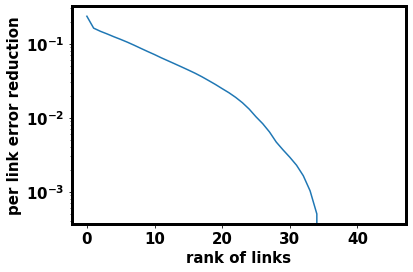

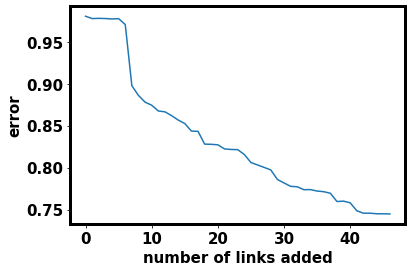

In [92]:
plt.figure()
plt.plot(np.cumsum(np.sort(df_added_tables['error reduced'].values))[::-1])
plt.yscale('log')
plt.ylabel('per link error reduction')
plt.xlabel('rank of links')

plt.figure()
plt.plot(error_list)
plt.ylabel('error')
plt.xlabel('number of links added')

## Generate p-value by comparing the added links to links in the MAMBO

3337 30994
0.10766599987094276
30
16
P-value is 1.1042837733787891e-05


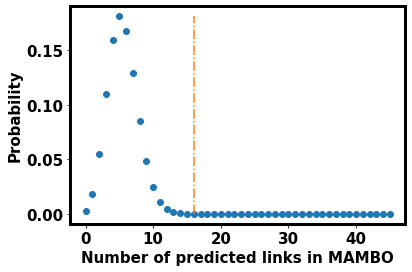

In [97]:
chia_microbes_in_Thai = df_microbes.reset_index().set_index('newID').loc[thai_metagenome_ID].values.flatten()
chia_metabolites_in_Thai = df_metabolites.reset_index().set_index('newID').loc[df_metabolites['newID']].values.flatten()

df_MAMBO = pd.read_csv("mambo_curated.txt", sep = '\t')
df_MAMBO_filtered = df_MAMBO[df_MAMBO['microbe_ID'].apply(lambda x: x in chia_microbes_in_Thai)]
df_MAMBO_filtered = df_MAMBO_filtered[df_MAMBO_filtered['metabolite_ID'].apply(lambda x: x in chia_metabolites_in_Thai)]

df_MAMBO_filtered_newID = df_MAMBO_filtered[['microbe_ID', 'metabolite_ID']].copy()
df_MAMBO_filtered_newID.columns = ['microbes', 'metabolites']
df_MAMBO_filtered_newID['microbes'] = df_microbes.loc[df_MAMBO_filtered_newID['microbes']].values
df_MAMBO_filtered_newID['metabolites'] = df_metabolites.loc[df_MAMBO_filtered_newID['metabolites']].values
s1 = df_MAMBO_filtered_newID
s2 = net[['metabolites', 'microbes']]
numOverlap = len(pd.merge(s1, s2, how='inner'))

print((len(df_MAMBO_filtered)-numOverlap), (x.shape[0] - len(net_ori)))
print((len(df_MAMBO_filtered)-numOverlap) / (x.shape[0] - len(net_ori)) )

k = 0
l = 0
ifIncluded = np.zeros((NUMADDED))
ifCovered = np.zeros((NUMADDED))
for i in range(NUMADDED):
    if (np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i])) >=1 and 
       np.sum((df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1):
        ifCovered[i] = 1
        l += 1
    if np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i]) & 
       (df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1:
        ifIncluded[i] = 1
        k += 1
print(l)
print(k)

from scipy.stats import bernoulli, binom
xx = range(NUMADDED)
p = len(df_MAMBO_filtered) / x.shape[0]
#prob = bernoulli.cdf(xx, p)
probCum = binom.cdf(xx, NUMADDED, p)
prob = binom.pmf(xx, NUMADDED, p)
plt.plot(xx, prob, 'o')
plt.plot([k, k], [0, np.max(prob)], '-.')
plt.xlabel('Number of predicted links in MAMBO')
plt.ylabel('Probability')
p_value = 1 - probCum[k]
print('P-value is',str(p_value))

## Generate p-value by comparing the added links to links in the Chia

0
P-value is 0.7030411684377345


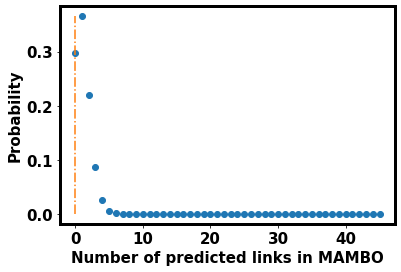

In [95]:
######## Select all microbes in the Thai data:
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = 0.05

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net_chia)

#m2b_ori = (m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
#b2m_ori = (b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
m2b_chia = (m2b!=0).astype(int).copy()
b2m_chia = (b2m!=0).astype(int).copy()
x_chia = np.concatenate([m2b_chia.flatten(), b2m_chia.flatten()])

k = np.sum(df_added_tables['position in x'].apply(lambda x: x in np.where(x_chia)[0]))
print(k)

from scipy.stats import bernoulli, binom
xx = range(NUMADDED)
p = int(len(net_chia) * (1-pDel)) / x_chia.shape[0]
#prob = bernoulli.cdf(xx, p)
probCum = binom.cdf(xx, NUMADDED, p)
prob = binom.pmf(xx, NUMADDED, p)
plt.plot(xx, prob, 'o')
plt.plot([k, k], [0, np.max(prob)], '-.')
plt.xlabel('Number of predicted links in MAMBO')
plt.ylabel('Probability')
p_value = 1 - probCum[k]
print('P-value is',str(p_value))

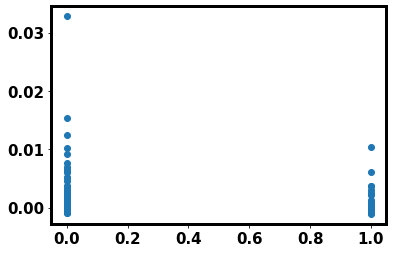

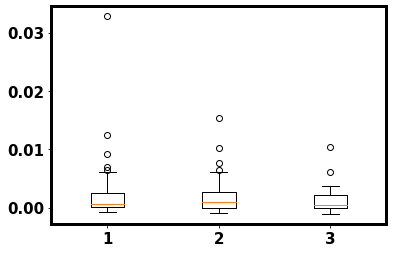

In [16]:
plt.figure()
plt.plot(ifIncluded, df_added_tables['error reduced'], 'o')

box1 = df_added_tables['error reduced'][ifCovered==0]
box2 = df_added_tables['error reduced'][(ifCovered==1) & (ifIncluded==0)]
box3 = df_added_tables['error reduced'][(ifCovered==1) & (ifIncluded==1)]
plt.figure()
plt.boxplot([box1, box2, box3]);


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8968525177196471
            Iterations: 16
            Function evaluations: 357
            Gradient evaluations: 16
     fun: 0.8968525177196471
     jac: array([0.        , 0.02251709, 0.01251958, 0.01356445, 0.02523565,
       0.01381337, 0.0399211 , 0.09130701, 0.0068116 , 0.11396237,
       0.009275  , 0.0284039 , 0.09073605, 0.1433911 , 0.02579552,
       0.04821868, 0.31784323, 0.01600764, 0.08630203, 0.11901642])
 message: 'Optimization terminated successfully.'
    nfev: 357
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([5.00000000e-02, 0.00000000e+00, 1.63403946e+00, 7.32913763e-02,
       1.98277275e-01, 1.72023925e+00, 1.97794557e-16, 1.80930463e-16,
       2.34486183e-04, 1.96657483e-16, 1.43348742e-01, 0.00000000e+00,
       1.38135759e-16, 1.48352270e-16, 7.31701852e-01, 6.14763907e-16,
       1.09285611e-16, 2.90570224e-01, 3.91425820e-16, 1.70112409e-16

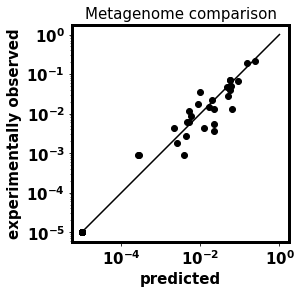

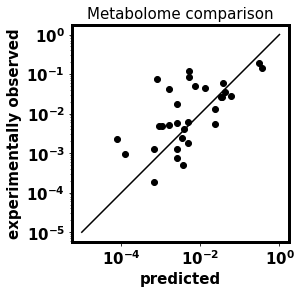

In [17]:
################################# Predict metabolome from individual's metagenome.

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 3; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net_new)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))


In [18]:
from scipy.stats import pearsonr, spearmanr
print(pearsonr(metabolome_pred_common, metabolome_measured_common))
print(spearmanr(metabolome_pred_common, metabolome_measured_common))
print(pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5)))


(0.7644001155943676, 5.57686958976285e-07)
SpearmanrResult(correlation=0.6334181922569049, pvalue=0.0001308405225019385)
(0.6226083503338306, 0.00018382600176907707)
